In [10]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import sys, pickle
from importlib import reload
from tqdm import tqdm, trange

import numpy as np, pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm

import agama 
agama.setUnits(mass=1, length=1, velocity=1) #Msol, kpc, km/s. Time is in kpc/(kms/s)
# agama.setNumThreads(48)  

# sys.path.insert(1, '/mnt/d/Research/')
# import compute_characteristics_ut as cc

sys.path.append('../scripts/')
import stream_sim_funcs as ssf

import emcee

from astropy import units as u
import astropy.coordinates as coord
from astropy.coordinates import Galactocentric, ICRS, CartesianDifferential, CartesianRepresentation
from astropy import table

from aau_likelihood import log_likelihood, make_spline, log_prior, log_probability

Constructing the AGAMA, MW+LMC potential

In [11]:
# AGAMA like MW-LMC Potential

# Create a simple but realistic model of the Milky Way with a bulge, a single disk,
# and a spherical dark halo
paramBulge = dict(
    type              = 'Spheroid',
    mass              = 1.2e10,
    scaleRadius       = 0.2,
    outerCutoffRadius = 1.8,
    gamma             = 0.0,
    beta              = 1.8)
paramDisk  = dict(
    type='MiyamotoNagai',
    mass              = 5.0e10,
    scaleRadius       = 3.0,
    scaleHeight       = 0.3)
paramHalo  = dict(
    type              = 'Spheroid',
    densityNorm       = 1.35e7,
    scaleRadius       = 14,
    outerCutoffRadius = 300,
    cutoffStrength    = 4,
    gamma             = 1,
    beta              = 3)

densMWhalo = agama.Density(paramHalo)
potMW      = agama.Potential(paramBulge, paramDisk, paramHalo)

# Create the LMC potential - a spherical truncated NFW profile with mass and radius
# related by the equation below, which produces approximately the same enclosed mass
# profile in the inner region, satisfying the observational constraints, as shown
# in Fig.3 of Vasiliev,Belokurov&Erkal 2021.
massLMC    = 1.5e11
radiusLMC  = (massLMC/1e11)**0.6 * 8.5
bminCouLog = radiusLMC * 2.0   # minimum impact parameter in the Coulomb logarithm
potLMC     = agama.Potential(
    type              = 'spheroid',
    mass              = massLMC,
    scaleradius       = radiusLMC,
    outercutoffradius = radiusLMC*10,
    gamma             = 1,
    beta              = 3)


# Define file paths
BASE_POT_PATH = 'MW_LMC_pot/'
accMW_path = os.path.join(BASE_POT_PATH, 'accMW')
trajLMC_path = os.path.join(BASE_POT_PATH, 'trajLMC')

# Check if saved files exist
files_exist = os.path.exists(accMW_path) and os.path.exists(trajLMC_path)

if files_exist:
    try:
        print('Loading precomputed MW-LMC potential files...')
        accMW = np.loadtxt(accMW_path)
        trajLMC = np.loadtxt(trajLMC_path)
        potacc  = agama.Potential(type='UniformAcceleration', file=accMW)
        potLMCm = agama.Potential(potential=potLMC, center=trajLMC)
        potTotal= agama.Potential(potMW, potLMCm, potacc)
        print('Successfully loaded MW-LMC potential.')
    except Exception as e:
        print(f'Error loading files: {e}')
        print('Will recompute...')
        files_exist = False

if not files_exist:
    print('Computing the MW-LMC potential from scratch...')
    
    import scipy.integrate, scipy.ndimage, scipy.special
    Trewind = -4.0  # initial time [Gyr] - the LMC orbit is computed back to that time
    Tcurr   =  0.0  # current time
    # heliocentric ICRS celestial coordinates and velocity of the LMC
    # (PM from Luri+ 2021, distance from Pietrzynski+ 2019, center and velocity from van der Marel+ 2002)
    ra, dec, dist, pmra, pmdec, vlos = 81.28, -69.78, 49.6, 1.858, 0.385, 262.2
    # transform to Galactocentric cartesian position/velocity, using built-in routines from Agama
    # (hence the manual conversion factors from degrees to radians and from mas/yr to km/s/kpc)
    l, b, pml, pmb = agama.transformCelestialCoords(agama.fromICRStoGalactic,
        ra * np.pi/180, dec * np.pi/180, pmra, pmdec)
    posvelLMC = agama.getGalactocentricFromGalactic(l, b, dist, pml*4.74, pmb*4.74, vlos)
    
    # create a sphericalized MW potential and a corresponding isotropic halo distribution function
    potMWsph   = agama.Potential(type='Multipole', potential=potMW, lmax=0, rmin=0.01, rmax=1000)
    gmHalo     = agama.GalaxyModel(potMWsph,
        agama.DistributionFunction(type='quasispherical', density=densMWhalo, potential=potMWsph))
    
    # compute the velocity dispersion in the MW halo needed for the dynamical friction
    rgrid      = np.logspace(1, 3, 16)
    xyzgrid    = np.column_stack([rgrid, rgrid*0, rgrid*0])
    sigmafnc   = agama.Spline(rgrid, gmHalo.moments(xyzgrid, dens=False, vel=False, vel2=True)[:,0]**0.5)
    
    ######## PART ONE ########
    # Simulate (approximately!) the past trajectory of the MW+LMC system under mutual gravity.
    # Here, we integrate in time a 12-dimensional ODE system for positions & velocities of
    # both galaxies in the external inertial reference frame. The acceleration of each galaxy
    # is computed by taking the gradient of the rigid (non-deforming) potential of the other
    # galaxy at the location of the first galaxy's center, and then assuming that the entire
    # first galaxy experiences the same acceleration and continues to move as a rigid body.
    # The same procedure then is applied in reverse. Moreover, we add a dynamical friction
    # acceleration to the LMC, but not to the Milky Way; it is computed using the standard
    # Chandrasekhar's formula, but with a spatially-varying value of Coulomb logarithm,
    # which has been calibrated against full N-body simulations.
    # This simplified model is certainly not physically correct, e.g. manifestly violates
    # Newton's third law, but still captures the main features of the actual interaction.
    print("Computing the past orbits of the Milky Way and the LMC")
    def difeq(vars, t):
        x0    = vars[0:3]          # MW position
        v0    = vars[3:6]          # MW velocity
        x1    = vars[6:9]          # LMC position
        v1    = vars[9:12]         # LMC velocity
        dx    = x1-x0              # relative offset
        dv    = v1-v0              # relative velocity
        dist  = sum(dx**2)**0.5    # distance between the galaxies
        vmag  = sum(dv**2)**0.5    # magnitude of relative velocity
        f0    = potLMC.force(-dx)  # force from LMC acting on the MW center
        f1    = potMW .force( dx)  # force from MW acting on the LMC
        rho   = potMW.density(dx)  # actual MW density at this point
        sigma = sigmafnc(dist)     # approximate MW velocity dispersion at this point
        # distance-dependent Coulomb logarithm
        # (an approximation that best matches the results of N-body simulations)
        couLog= max(0, np.log(dist / bminCouLog)**0.5)
        X     = vmag / (sigma * 2**.5)
        drag  = -(4*np.pi * rho * dv / vmag *
            (scipy.special.erf(X) - 2/np.pi**.5 * X * np.exp(-X*X)) *
            massLMC * agama.G**2 / vmag**2 * couLog)   # dynamical friction force
        return np.hstack((v0, f0, v1, f1 + drag))
    
    Tstep   = 1./100
    tgrid   = np.linspace(Trewind, Tcurr, round((Tcurr-Trewind)/Tstep)+1)
    ic      = np.hstack((np.zeros(6), posvelLMC))
    sol     = scipy.integrate.odeint(difeq, ic, tgrid[::-1])[::-1]
    
    # After obtaining the solution for trajectories of both galaxies,
    # we transform it into a more convenient form, namely, into the non-inertial
    # reference frame centered at the Milky Way center at all times.
    # In this frame, the total time-dependent gravitational potential consists of
    # three terms. First is the rigid potential of the Milky Way itself.
    # Because the latter moves on a curvilinear trajectory, we need to add
    # a corresponding spatially uniform acceleration field. Finally, the potential
    # of the LMC is also rigid but moves in space.
    
    # LMC trajectory in the MW-centric (non-inertial) reference frame
    # (7 columns: time, 3 position and 3 velocity components)
    trajLMC = np.column_stack([tgrid, sol[:,6:12] - sol[:,0:6]])
    # MW trajectory in the inertial frame
    trajMWx = agama.Spline(tgrid, sol[:,0], der=sol[:,3])
    trajMWy = agama.Spline(tgrid, sol[:,1], der=sol[:,4])
    trajMWz = agama.Spline(tgrid, sol[:,2], der=sol[:,5])
    # MW centre acceleration is minus the second derivative of its trajectory in the inertial frame
    accMW   = np.column_stack([tgrid, -trajMWx(tgrid, 2), -trajMWy(tgrid, 2), -trajMWz(tgrid, 2)])
    potacc  = agama.Potential(type='UniformAcceleration', file=accMW)
    potLMCm = agama.Potential(potential=potLMC, center=trajLMC)
    
    # finally, the total time-dependent potential in the non-inertial MW-centric reference frame
    potTotal= agama.Potential(potMW, potLMCm, potacc)

    # Save results to disk
    try:
        # Create directory if it doesn't exist
        os.makedirs(BASE_POT_PATH, exist_ok=True)
        
        np.savetxt(accMW_path, accMW, 
                   header='Time[Gyr], a_x[km/s/Gyr], a_y[km/s/Gyr], a_z[km/s/Gyr]')
        np.savetxt(trajLMC_path, trajLMC, 
                   header='Time[Gyr], x[kpc], y[kpc], z[kpc], vx[km/s], vy[km/s], vz[km/s]')
        print(f'Successfully saved MW-LMC potential files to {BASE_POT_PATH}')
    except Exception as e:
        print(f'Warning: Could not save potential files: {e}')
        print('Potential has been computed but not saved to disk.')

Loading precomputed MW-LMC potential files...
Successfully loaded MW-LMC potential.


In [12]:
#Reading in all our data
member_path = '../data/aau_members.csv'
distance_path = '../data/aau_bhb_rrl.csv'

s5_table = pd.read_csv(member_path)
bhb_rrl_data = pd.read_csv(distance_path)

#print(len(s5_table))

In [13]:
#coordinate transform
def icrs_to_aau(ra_rad, dec_rad):
    """
    define a *differentiable* coordinate transfrom from ra and dec --> AAU phi1, phi2
    Using the rotation matrix from Shipp+2019
    ra_rad: icrs ra [radians]
    dec_red: icrs dec [radians]
    """
    R = np.array(
        [
            [0.83697865, 0.29481904, -0.4610298],
            [0.51616778,-0.70514011, 0.4861566],
            [0.18176238, 0.64487142, 0.74236331],
        ]
    )

    icrs_vec = np.vstack(
        [
            np.cos(ra_rad) * np.cos(dec_rad),
            np.sin(ra_rad) * np.cos(dec_rad),
            np.sin(dec_rad),
        ]
    ).T

    stream_frame_vec = np.einsum("ij,kj->ki", R, icrs_vec)

    phi1 = np.arctan2(stream_frame_vec[:, 1], stream_frame_vec[:, 0]) * 180 / np.pi
    phi2 = np.arcsin(stream_frame_vec[:, 2]) * 180 / np.pi

    return phi1, phi2

In [14]:
#Deciding stream IC's

#from MCMC
prog_coords_today = [25.33, -29.93, 26.05, 0.09, -0.64, -84.97]

ra, dec, dist, pmra, pmdec, rv = prog_coords_today

aau_c = coord.SkyCoord(
    ra=ra*u.degree, dec=dec*u.degree, distance=dist*u.kpc, 
    pm_ra_cosdec=pmra*u.mas/u.yr,
    pm_dec=pmdec*u.mas/u.yr,
    radial_velocity=rv*u.km/u.s
)

rep = aau_c.transform_to(coord.Galactocentric) # units here are kpc, km/s

prog_wtoday = np.array(
    [rep.x.value, rep.y.value, rep.z.value,
     rep.v_x.value, rep.v_y.value, rep.v_z.value]
) # units here are kpc, km/s


# # stream progenitor profile parameters
prog_mass, prog_scaleradius =  8e6, 10/1_000 # Msun, kpc
Age_stream_inGyr = 3.5 # Gyr --<

# # num_particles for the spray model: 
num_particles = 1_000 # # preferably a multiple of 2, leading+trailing arm

In [15]:
%%time

# Test out a particle-spray simulation
stream_unperturb = ssf.create_stream_particle_spray(
    pot_host=potTotal, 
    initmass=prog_mass, 
    scaleradius=prog_scaleradius, 
    prog_pot_kind='Plummer', 
    sat_cen_present=prog_wtoday, 
    num_particles=num_particles,
    time_end=0.0, 
    time_total=Age_stream_inGyr, save_rate=1,
    #add_perturber={'mass':0},
)


CPU times: user 10.2 s, sys: 201 ms, total: 10.4 s
Wall time: 56.6 ms


In [16]:
# from astropy.coordinates import Galactocentric, ICRS
# import astropy.units as u
# import numpy as np

# # Input array: shape (N,6) -> x, y, z, v_x, v_y, v_z
# part_xv = stream_unperturb['part_xv']

# # Split positions and velocities
# x = part_xv[:, 0] * u.kpc
# y = part_xv[:, 1] * u.kpc
# z = part_xv[:, 2] * u.kpc
# v_x = part_xv[:, 3] * u.km/u.s
# v_y = part_xv[:, 4] * u.km/u.s
# v_z = part_xv[:, 5] * u.km/u.s

# # Build Galactocentric coordinates
# galcen_coords = Galactocentric(
#     x=x, y=y, z=z,
#     v_x=v_x, v_y=v_y, v_z=v_z
# )

# # Transform to ICRS
# icrs_coords = galcen_coords.transform_to(ICRS())

# # Proper motions in mas/yr
# pmra = icrs_coords.pm_ra_cosdec.to(u.mas/u.yr)
# pmdec = icrs_coords.pm_dec.to(u.mas/u.yr)

# # Radial velocity in km/s
# v_radial = icrs_coords.radial_velocity.to(u.km/u.s)

# # Pack into numpy array: [ra, dec, distance, pmra, pmdec, v_radial]
# icrs_array = np.column_stack([
#     icrs_coords.ra.deg,
#     icrs_coords.dec.deg,
#     icrs_coords.distance.kpc,
#     pmra.value,
#     pmdec.value,
#     v_radial.value
# ])

# print(icrs_array.shape)  # Should be (N,6)


In [17]:
# #plt.plot(icrs_array[:,3], icrs_array[:,5], '.')
# plt.plot(data_dict['phi1_obs'], data_dict['rv_obs'], '.')
# # pmra_cosdec_obs = s5_table['ra'].values
# # pmdec_obs = s5_table['dec'].values
# # plt.plot(pmra_cosdec_obs, pmdec_obs, '.')

In [18]:
def select_median_array(data_file, distance_file):
    
    '''
    Function takes in two tables -- one large data table, and one distance table.
    '''
    
    df = data_file
    df_distance = distance_file

    select_phi1 = (df['phi1'] > -5.7) & (df['phi1'] < -5.4)

    coefficients = np.polyfit(distance_file['Phi1'], distance_file['Distance_Modulus'], deg=2)
    
    distance_fit = np.poly1d(coefficients)
    dist_kpc_data = (10 ** ((distance_fit(df['phi1']))/5 +1))*1e-3

    phi1med = np.median(df.loc[select_phi1,'phi1'])
    phi2med = np.median(df.loc[select_phi1,'phi2'])
    distmed = np.median(dist_kpc_data)
    ramed = np.median(df.loc[select_phi1,'ra'])
    decmed = np.median(df.loc[select_phi1,'dec'])
    pmramed = np.median(df.loc[select_phi1, 'pmra'])
    pmdecmed = np.median(df.loc[select_phi1, 'pmdec'])
    rvmed = np.median(df.loc[select_phi1, 'vel_calib'])

    prog_pars = [float(ramed), float(decmed), float(distmed), float(pmramed), float(pmdecmed), float(rvmed)]

    return df, df_distance, dist_kpc_data, prog_pars

In [24]:
df, df_distance, dist_kpc_data, prog_pars = select_median_array(s5_table, bhb_rrl_data)

print(s5_table)

      vel_blue1  vel_blue16  vel_blue50  vel_blue84  vel_blue99  \
0   -194.449217 -167.555038 -147.495404 -127.244391  -97.892507   
1     -3.591715   -2.185699   -1.108446   -0.068246    1.283278   
2    -22.901434  -19.826863  -17.760587  -15.657125  -13.124182   
3    -46.834272  -45.245055  -43.876414  -42.507097  -40.627042   
4   -114.229655 -103.521117  -95.252276  -86.522046  -73.744107   
..          ...         ...         ...         ...         ...   
135 -152.322086 -140.286665 -131.546049 -122.312909 -109.236808   
136 -163.449431 -162.551153 -161.899130 -161.215750 -160.382126   
137  -91.680296  -81.671298  -74.821026  -67.476780  -57.667251   
138 -110.265672 -101.302480  -94.671783  -88.361805  -79.721865   
139 -156.698495 -137.370211 -123.100967 -108.091006  -86.751633   

     vel_blue_mean  vel_blue_std  vel_blue_kurt  vel_blue_skew        vel1  \
0      -147.335595     20.423728       0.045678       0.087367 -149.593878   
1        -1.123138      1.049611      -

In [11]:
data_dict = dict(
    phi1_obs = df['phi1'].values,
    phi2_obs = df['phi2'].values,
    rv_obs = df['vel_calib'].values,
    rv_obs_errors = df['vel_calib_std'].values,
    dist_obs = dist_kpc_data,
    dist_obs_errors = (dist_kpc_data*0.1),
    pmra_cosdec_obs = df['pmra'].values,
    pmra_cosdec_obs_errors = df['pmra_error'].values,
    pmdec_obs = df['pmdec'].values,
    pmdec_obs_errors = df['pmdec_error'].values,
)

In [12]:
nwalkers = 48
niter = 1000

#Taking a fraction of the prior range 
initial = prog_pars
ndim = len(initial)
p0 = [np.array(initial) + 1e-3 * np.random.randn(ndim) for i in range(nwalkers)]

data = (data_dict, potTotal)

In [13]:
def main(p0,nwalkers,niter,ndim,log_probability,data, nburnin=100):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=data)
    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, nburnin, progress = True)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter, progress = True)

    return sampler, pos, prob, state

In [14]:
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,log_probability, data)

Running burn-in...


100%|██████████| 100/100 [04:32<00:00,  2.72s/it]


Running production...


 76%|███████▋  | 764/1000 [30:39<09:58,  2.54s/it]Traceback (most recent call last):
  File "/astro/users/arora125/miniforge3/envs/Nbodystream/lib/python3.12/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/astro/users/shriyp/aau_sbi_fastsims/notebooks/../scripts/aau_likelihood.py", line 331, in log_probability
    return lp + log_likelihood(prog_pars,**data_dict,pot=pot)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/astro/users/shriyp/aau_sbi_fastsims/notebooks/../scripts/aau_likelihood.py", line 205, in log_likelihood
    stream_unperturb = create_stream_particle_spray(pot_host=pot,
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/astro/users/shriyp/aau_sbi_fastsims/notebooks/../scripts/stream_sim_funcs.py", line 1129, in create_stream_particle_spray
    part_xv = np.stack([orbit(save_times) for orbit in result], axis=0)
   

emcee: Exception while calling your likelihood function:
  params: [ 24.72594659 -30.62419226  25.87193862   0.14539235  -0.58855341
 -85.30434353]
  args: ({'phi1_obs': array([ 10.89989457, -16.64708197, -12.23807984, -12.29400688,
        -4.69962039,   8.99805373,  -6.48510117,   7.31981844,
        -0.58387573,   0.80319203, -15.49821538, -11.58762177,
        -6.90782189,  10.49897822,  13.70063147, -19.10611405,
        -8.16150373,   1.55021812,   1.50428129,  13.6617757 ,
       -16.04862635, -13.87276141, -13.41225069, -11.6967751 ,
       -13.35241276,  -9.72925763, -11.30806054, -10.02575757,
       -18.53171127, -16.0559481 , -15.14382513, -11.40869312,
        -6.16339144,   3.44251693,  -6.23684694, -13.1279601 ,
       -11.49391862, -15.89008407,  -6.21731557,  -9.56279403,
        -1.38074151,  -1.16713446,   9.57433589,  12.16052811,
       -21.23376827, -16.45459169, -15.08296876, -10.92384081,
        -1.38111714, -11.88348248,  -9.44890185,   0.37570813,
         7.

KeyboardInterrupt: 

In [15]:
# test_result = log_likelihood(
#     prog_pars=initial,
#     phi1_obs = df['phi1'].values,
#     phi2_obs = df['phi2'].values,
#     rv_obs = df['vel_calib'].values,
#     rv_obs_errors = df['vel_calib_std'].values,
#     dist_obs = dist_kpc_data,
#     dist_obs_errors = (dist_kpc_data*0.1),
#     pmra_cosdec_obs = df['pmra'].values,
#     pmra_cosdec_obs_errors = df['pmra_error'].values,
#     pmdec_obs = df['pmdec'].values,
#     pmdec_obs_errors = df['pmdec_error'].values,
#     pot=potTotal,
#     phi1_range=[-20, 15]
# )
# print(f"Test likelihood with initial params: {test_result}")

In [34]:
samples = sampler.flatchain
prog_pars_max  = samples[np.argmax(sampler.flatlnprobability)]
print(prog_pars_max)
# print(prog_best_fit)
# r_vec = [prog_best_fit[0], prog_best_fit[1], prog_best_fit[2]]
# r_mag = np.linalg.norm(r_vec)
# v_vec = [prog_best_fit[3], prog_best_fit[4], prog_best_fit[5]]

# v_rad = (np.dot(v_vec, r_vec))/r_mag

# print(v_rad)



[ 24.96479925 -30.51605382  25.70432373   0.42121239  -0.81779829
 -85.82817145]
[-11.1362987   -3.98786443 -25.19274871  46.25609241 150.22261972
 106.37623809]
-136.32369954262936


In [40]:
#Best-fit Stream IC's from MCMC

ra_best, dec_best, dist_best, pmra_best, pmdec_best, rv_best = prog_pars_max

aau_c_best = coord.SkyCoord(
    ra=ra_best*u.degree, dec=dec_best*u.degree, distance=dist_best*u.kpc, 
    pm_ra_cosdec=pmra_best*u.mas/u.yr,
    pm_dec=pmdec_best*u.mas/u.yr,
    radial_velocity=rv_best*u.km/u.s
)

rep_best = aau_c_best.transform_to(coord.Galactocentric) # units here are kpc, km/s

prog_best_gal = np.array(
    [rep_best.x.value, rep_best.y.value, rep_best.z.value,
     rep_best.v_x.value, rep_best.v_y.value, rep_best.v_z.value]
) # units here are kpc, km/s


# # stream progenitor profile parameters
prog_mass, prog_scaleradius =  20_000, 10/1_000 # Msun, kpc
Age_stream_inGyr = 3.5 # Gyr --<

# # num_particles for the spray model: 
num_particles = 1_000 # # preferably a multiple of 2, leading+trailing arm

In [16]:
stream_best = ssf.create_stream_particle_spray(
    pot_host=potTotal, 
    initmass=prog_mass, 
    scaleradius=prog_scaleradius, 
    prog_pot_kind='Plummer', 
    sat_cen_present=prog_best_fit, 
    num_particles=num_particles,
    time_end=0.0, 
    time_total=Age_stream_inGyr, save_rate=1,
    #add_perturber={'mass':0},
)

NameError: name 'prog_best_gal' is not defined

In [43]:
galcen_best_stream = coord.Galactocentric(
        x=stream_best[:,0] * u.kpc,
        y=stream_best[:,1] * u.kpc,
        z=stream_best[:,2] * u.kpc,
        v_x=stream_best[:,3] * u.km/u.s,
        v_y=stream_best[:,4] * u.km/u.s,
        v_z=stream_best[:,5] * u.km/u.s,
        representation_type='cartesian',
        differential_type='cartesian'
    )

In [17]:
icrs_best_stream = galcen_best_stream.transform_to(coord.ICRS())

NameError: name 'galcen_best_stream' is not defined

In [18]:
ra_max = icrs_best_stream.ra.to(u.radian).value
dec_max = icrs_best_stream.dec.to(u.radian).value
dist_max = icrs_best_stream.distance.value
pmra_max = icrs_best_stream.pm_ra_cosdec.value
pmdec_max = icrs_best_stream.pm_dec.value
rv_max = icrs_best_stream.radial_velocity.value

NameError: name 'icrs_best_stream' is not defined

In [19]:
phi1_max, phi2_max = icrs_to_aau(ra_max, dec_max)

NameError: name 'ra_max' is not defined

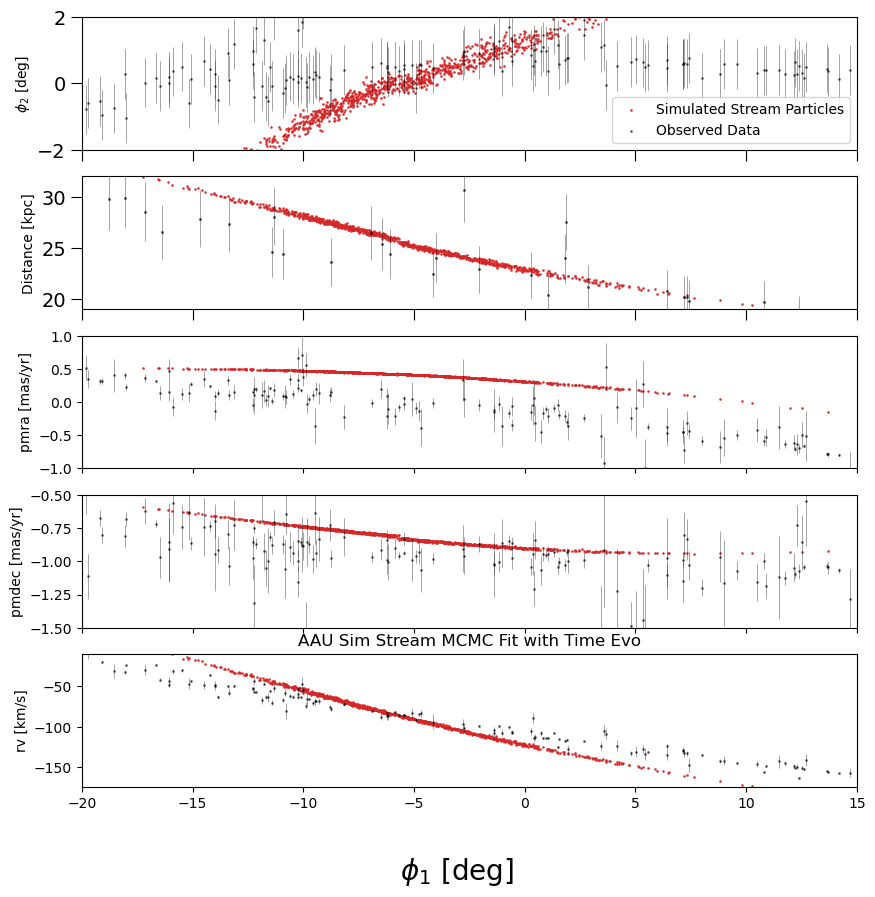

In [47]:
#plot with median values as progenitor parameters!
fig, ax = plt.subplots(5,1, sharex = True)
fig.set_size_inches(10,10)
fig.supxlabel(r'$\phi_1$ [deg]',fontsize=20)
ax[-1].set_xlim(-20,15)
ax[-1].set_title(label ='AAU Sim Stream MCMC Fit with Time Evo')
#simulation
ax[0].scatter(phi1_max, phi2_max,s=0.75,color='tab:red', alpha= 0.9, label = 'Simulated Stream Particles')
ax[0].tick_params(axis='both', which='major', labelsize=14., length=8)
ax[0].tick_params(axis='both', which='minor', length=3)
ax[0].set_ylim(-2,2)

ax[0].set_ylabel(r'$\phi_2$ [deg]', fontsize=10)
ax[1].scatter(phi1_max, dist_max,s=0.75,color='tab:red',alpha= 0.9 )
ax[1].tick_params(axis='both', which='major', labelsize=14., length=8)
ax[1].tick_params(axis='both', which='minor', length=3)
ax[1].set_ylabel('Distance [kpc]', fontsize=10)
ax[1].set_ylim(19,32)

ax[2].scatter(phi1_max, pmra_max,s=0.75,color='tab:red',alpha= 0.9 )
ax[2].set_ylim(-1,1)
ax[2].set_ylabel('pmra [mas/yr]', fontsize=10)

ax[3].scatter(phi1_max, pmdec_max,s=0.75,color='tab:red',alpha= 0.9 )
ax[3].set_ylabel('pmdec [mas/yr]', fontsize=10)
ax[3].set_ylim(-1.5,-0.5)

ax[4].scatter(phi1_max, rv_max,s=0.75,color='tab:red',alpha= 0.9)
ax[4].set_ylabel('rv [km/s]', fontsize=10)
ax[4].set_ylim(-175,-10)

#data
ax[0].scatter(df['phi1'], df['phi2'] , s=1,color='k', alpha = 0.5, label = 'Observed Data')
ax[0].errorbar(df['phi1'], df['phi2'], yerr=np.nanstd(df['phi2']), fmt='none', ecolor='k', alpha = 0.5, capsize=0, capthick=0.7, elinewidth=0.5)

ax[1].scatter(df_distance['Phi1'],(10**((df_distance['Distance_Modulus'])/5 +1)*1e-3),s=1.5,color='k', alpha = 0.5)
ax[1].errorbar(df_distance['Phi1'],(10**((df_distance['Distance_Modulus'])/5 +1)*1e-3), yerr=np.abs(((10**((df_distance['Distance_Modulus'])/5 +1)*1e-3))*0.1), fmt='none', ecolor='k',alpha = 0.5,capsize=0, capthick=0.7, elinewidth=0.5)


ax[2].scatter(df['phi1'], df['pmra'],s=1,color='k', alpha = 0.5)
ax[2].errorbar(df['phi1'], df['pmra'], yerr=df['pmra_error'], fmt='none', ecolor='k',alpha = 0.5,capsize=0, capthick=0.7, elinewidth=0.5)

ax[3].scatter(df['phi1'], df['pmdec'],s=1,color='k',alpha = 0.5)
ax[3].errorbar(df['phi1'], df['pmdec'], yerr=df['pmdec_error'], fmt='none', ecolor='k', alpha = 0.5, capsize=0, capthick=0.7, elinewidth=0.5)

ax[4].scatter(df['phi1'], df['vel_calib'],s=1,color='k', alpha = 0.5)
ax[4].errorbar(df['phi1'], df['vel_calib'], yerr=df['vel_calib_std'], fmt='none', ecolor='k',alpha = 0.5, capsize=0, capthick=0.7, elinewidth=0.5)

ax[0].legend(loc = 'lower right')

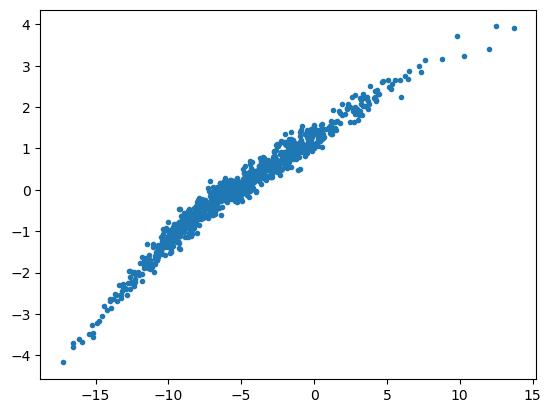

In [37]:
plt.plot(phi1_max,phi2_max, '.')